# iMaterialize kaggle competition

In this competition we are asked to classify furniture images into 128 classes. 

Datased contains thousands of images per class but as long as I am using Google Colab, I will just use some of them and apply the built-in image augmentation class provided by Keras. 

With this small project I wanted to get used to use Keras default generators and apply a kind of 'transfer' learning using a model trained on imagenet on a different problem.

The organization just provided the URLs to get the images from. Images have been downloaded in a separate process and zipped into a file. That file was uploaded to Google drive. In this Jupyter notebook we download the zipped file and start working with the images.

In [0]:
import os

os.makedirs('./dataset/')
os.makedirs('./tmp/')

# Download dataset

In [0]:
# Function to download file from google drive

import requests
import sys

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    


In [0]:
# Download actual files from drive

#https://drive.google.com/open?id=XXXXXXXXX
# TAKE ID FROM SHAREABLE LINK
file_id_val = 'XXXXXXX'
# DESTINATION FILE ON YOUR DISK
destination_val = './validation.zip'

# Usage: python google_drive.py drive_file_id destination_file_path
download_file_from_google_drive(file_id_val, destination_val)

#https://drive.google.com/open?id=XXXXXXX
# TAKE ID FROM SHAREABLE LINK
file_id_train = 'XXXXXXX'
# DESTINATION FILE ON YOUR DISK
destination_train = './train.zip'

# Usage: python google_drive.py drive_file_id destination_file_path
download_file_from_google_drive(file_id_train, destination_train)


In [0]:
#unzip 

import zipfile

zip_ref = zipfile.ZipFile('./validation.zip', 'r')
zip_ref.extractall('./dataset/')
zip_ref.close()

zip_ref = zipfile.ZipFile('./train.zip', 'r')
zip_ref.extractall('./dataset/')
zip_ref.close()

# Display an image of the dataset

In [0]:
# Global vars

DIR_DS = './dataset/'
DIR_OUTPUT = './output/'
DIR_TMP = './tmp/'

DIR_TRAIN = DIR_DS + 'train/'
DIR_VAL = DIR_DS + 'validation/'
DIR_TEST = DIR_DS + 'test/Test/'

MAX_EXAMPLES = 20 # Number of examples for each category

In [0]:
os.mkdir ('dataset')
os.mkdir ('output')
os.mkdir ('tmp')

Image has shape: (800, 800, 3)


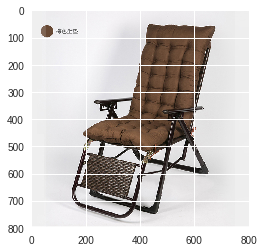

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

test_img_id = '89864'
label_id = '1'

sample_img_path = os.path.join(DIR_TRAIN,os.path.join(label_id, test_img_id+'.jpg'))
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img)
print ('Image has shape: {}'.format(sample_img.shape))

# Building the model

We will take profit of the excellent feature extraction of the Xception pre-built model trained on imagenet. Based on the Xception model, we will add our custom classifier on top of it. The classifier is just a shallow neural network that outputs 128 values applying softmax function. 

In [9]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

# Our classifier
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(2048, activation='relu')(x)
x = Dropout (0.2)(x)
# one fully connected layer more
x = Dense(1024, activation='relu')(x)
x = Dropout (0.2)(x)
# one fully connected layer more
x = Dense(512, activation='relu')(x)
x = Dropout (0.2)(x)
# and a logistic layer --
predictions = Dense(128, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional from base model layers
for layer in base_model.layers:
  layer.trainable = False

#for layer in base_model.layers[-6:]:
#  layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


83689472/83683744 [==============================] - 1s 0us/step


# Image augmentation 

We won't be using all of the data because of environment restrictions. So data augmentation becomes very important and using the convenient pre-built function in Keras is very easy.



In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = DIR_TRAIN
validation_data_dir = DIR_VAL
nb_train_samples = 19804
nb_validation_samples = 3000
epochs = 10
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator (rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 19804 images belonging to 128 classes.
Found 5153 images belonging to 128 classes.


# Training

In [0]:
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

print ('Saving the model...')
model.save(os.path.join('.','model.h5'))
print ('Model saved! Filename: {}'.format (os.path.join('.','model.h5')))

In [0]:
from google.colab import files

files.download('model.h5')

In [0]:
from keras.models import load_model
model = load_model(os.path.join('.','model.h5'))
print ('Model loaded!')

In [244]:
nb_evaluation_samples = 500

evaluation_datagen = ImageDataGenerator (rescale=1. / 255)

evaluation_generator = evaluation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

preds = model.evaluate_generator(evaluation_generator, steps=nb_evaluation_samples // batch_size)

print()
print ("Loss = " + str(preds[0]))
print ("Evaluation Accuracy = " + str(preds[1]))


Found 5153 images belonging to 128 classes.

Loss = 1.685432461000258
Evaluation Accuracy = 0.532258064516129


In [16]:
base_model.layers
for layer in base_model.layers[-6:]:
    print (layer)

In [0]:
model.save_weights('./top_model_w.h5')

Text(0.5,1,'Accuracy Curves')

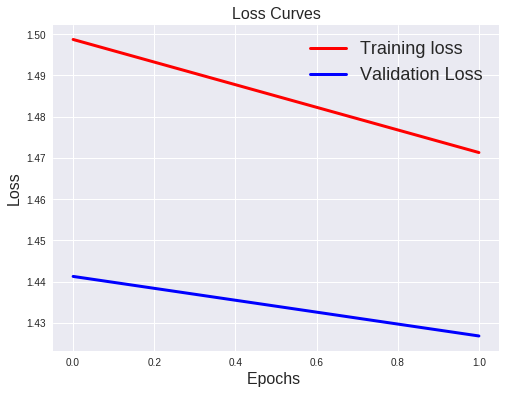

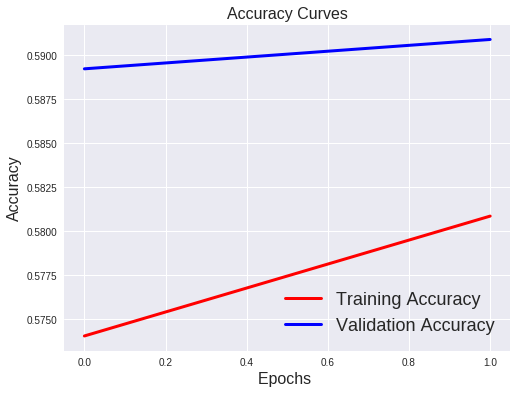

In [345]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [399]:
nb_evaluation_samples = 5153

evaluation_datagen = ImageDataGenerator (rescale=1./ 255)

evaluation_generator = evaluation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

preds = model_ft.evaluate_generator(evaluation_generator, steps=nb_evaluation_samples // batch_size)

print ("Loss = " + str(preds[0]))
print ("Evaluation Accuracy = " + str(preds[1]))

Found 5153 images belonging to 128 classes.

Loss = 1.4258911326435042
Evaluation Accuracy = 0.594138198757764


In [416]:
nb_evaluation_samples = 40

evaluation_datagen = ImageDataGenerator (rescale=1./ 255)

evaluation_generator = evaluation_datagen.flow_from_directory(
    './dataset/validation/',
    target_size=(img_width, img_height),
    batch_size=1,
    classes=['0'])

Found 0 images belonging to 1 classes.


In [347]:
submission_datagen = ImageDataGenerator (rescale=1./255)

submission_generator = submission_datagen.flow_from_directory(
        './dataset/test/Test/',
        target_size=(img_width, img_height),
        batch_size=1)

filenames = submission_generator.filenames
nb_samples = len(filenames

Found 0 images belonging to 0 classes.


In [48]:
for layer in model_2.layers[-14:]:
  print (layer)

# Prediction

In [0]:
#https://drive.google.com/open?id=XXXXXXXXXXXXXXXXXXX
# TAKE ID FROM SHAREABLE LINK
file_id_val = 'XXXXXXXXXXXXXXXXX'
# DESTINATION FILE ON YOUR DISK
destination_val = './test.zip'

# Usage: python google_drive.py drive_file_id destination_file_path
download_file_from_google_drive(file_id_val, destination_val)

In [0]:
zip_ref = zipfile.ZipFile('./test.zip', 'r')
zip_ref.extractall('./dataset/test')
zip_ref.close()

In [379]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input

import numpy as np

def predictFromPath (img_path, img_size=(img_width,img_height)):
  img = image.load_img(img_path, target_size=img_size)
  return predictFromImg (img)

def predictFromImg (img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  return model_ft.predict(x)
  
def getIndexFromPrediction (score):
  return np.argmax(score)

def getClassFromIndex (dictionary, index):
  for class_name, class_index in dictionary:
      if class_index == index:
          return class_name
        
def getClassFromPrediction (dictionary, score):
  return getClassFromIndex (dictionary, getIndexFromPrediction (score))
        
  
print (getClassFromIndex (train_generator.class_indices.items(), 0))


train_generator.classes

1


array([  0,   0,   0, ..., 127, 127, 127], dtype=int32)


Indexs ordered: 
[[  0  91  90  89  88  87  86  85  84  83  82  81  80  79  78  77  76  75
   74  73  72  71  70  69  68  67  65  64  92  93  94  95 125 124 123 122
  121 120 119 118 117 116 115 114 113 126 112 110 108 107 106 105 104 103
  102 101  99  98  97  96 111  62  63  60  28  27  26  25  24  23  22  21
   20  19  18  17  16  15  14  12  11  10   9   8   7   6   5   4   3   2
    1  61  30  29  32  59  58  57  56  55  54  53  52  51  50  49  48  47
   46  38  33  34  35  36  37  45  39 127  41  42  43  44  40 100  31  13
   66 109]]

Index 100 with prediction 1.5751303626159748e-30 class 74
Index 31 with prediction 6.549651402172789e-26 class 127
Index 13 with prediction 9.429990998977004e-25 class 110
Index 66 with prediction 1.294061817747459e-22 class 43
Index 109 with prediction 1.0 class 82

Index with highest value: 109
Probability: 1.0
Predicted class 82
Image has shape: (800, 800, 3)


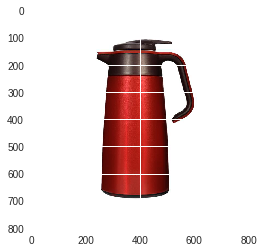

In [398]:
#from keras import np_utils

file_path = './dataset/validation/2/242.jpg'
prediction_ar = predictFromPath(file_path)


print ()
print ('Indexs ordered: \n{}\n'.format(np.argsort(prediction_ar)))
for prediction in np.argsort(prediction_ar[0])[-5:]:
  print ('Index {} with prediction {} class {}'.format(prediction, 
                                                     prediction_ar[0][prediction],
        getClassFromIndex(validation_generator.class_indices.items(), prediction)))

print()
print ('Index with highest value: {}'.format(getIndexFromPrediction(prediction_ar[0])))
print ('Probability: {}'.format(prediction_ar[0][getIndexFromPrediction(prediction_ar[0])]))
print ('Predicted class {}'.format(getClassFromIndex(validation_generator.class_indices.items(), getIndexFromPrediction(prediction_ar[0]))))

sample_img = plt.imread(file_path)
plt.imshow(sample_img)
print ('Image has shape: {}'.format(sample_img.shape))

Image has shape: (337, 450, 3)


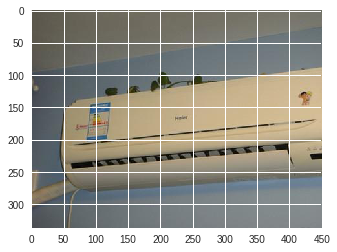

In [286]:
sample_img_path = './dataset/test/Test/4669.png'
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img)
print ('Image has shape: {}'.format(sample_img.shape))

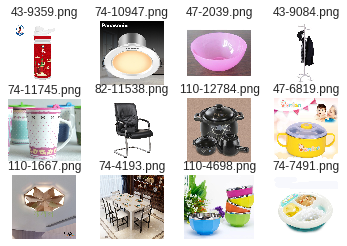

In [362]:
fig=plt.figure()

plot_test_paths = os.listdir(DIR_TEST)[:12]

for num,plot_test_path in enumerate(plot_test_paths):

    y = fig.add_subplot(3,4,num+1)
    orig = image.load_img (DIR_TEST+plot_test_path)

    prediction = predictFromPath (DIR_TEST+plot_test_path)
    str_label = getClassFromPrediction (train_generator.class_indices.items(), prediction[0])
        
    y.imshow(orig)
    plt.title(str(str_label)+'-'+plot_test_path)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

# Prediction on test images

In [0]:

import csv

submission_imgs = os.listdir(DIR_TEST)

with open(os.path.join(DIR_OUTPUT,'submission2.csv'), 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['id', 'predicted'])
    for elem in submission_imgs:
        prediction = getClassFromScore(predictFromPath (DIR_TEST+elem))
        filewriter.writerow([elem[:elem.index('.')], "{}".format(prediction)])

In [364]:
from shutil import copyfile

copyfile(os.path.join(DIR_OUTPUT,'submission2.csv'), './tmp/submission2.csv')

'./tmp/submission2.csv'

In [0]:
submission_id, submission_predicted = np.loadtxt('./output/submission2.csv', dtype={'names':('id','predicted'),
                                                          'formats':('i4','i4')},
    delimiter=',', skiprows=1, unpack=True)

In [366]:
with open(os.path.join(DIR_OUTPUT,'submission2.csv'), 'a') as csvfile:
  counter = 0
  for elem in np.arange(1,12800):
    if elem not in submission_id:
      csvfile.write("{},{}\n".format(elem, 1))
      counter += 1
  print ('{} elements were added'.format(counter))    

390 elements were added


In [367]:
with open('./output/submission2.csv', 'r') as fin:
    print (fin.read())

id,predicted
9359,67
10947,101
2039,71
9084,67
11745,101
11538,110
12784,14
6819,71
1667,14
4193,101
4698,14
7491,101
11254,71
6267,71
4435,110
9868,14
6426,101
7329,71
11660,125
9972,110
985,67
7435,67
17,28
15,110
499,110
4769,101
2770,14
4521,14
1901,101
1833,101
659,101
5719,101
1518,14
12221,67
8287,110
4448,67
1381,71
3408,101
12764,110
2749,14
8623,110
10236,110
4041,101
9703,110
2352,14
11792,101
2414,14
11297,71
7534,110
6657,71
88,101
11103,14
4467,14
8313,32
2889,101
5855,14
12478,14
2278,101
9198,71
955,32
4665,101
61,14
4508,110
4207,110
5887,101
5026,14
4781,125
12053,110
244,110
3421,101
12387,110
6473,14
6169,14
11128,14
3129,110
8654,110
2759,101
4469,110
3734,14
1079,110
1049,14
8891,14
10690,101
1566,101
1877,14
5890,110
1380,101
266,20
6346,14
12748,14
7322,32
8760,101
5823,71
10940,101
5463,48
10313,110
10380,110
2421,71
7548,14
2116,101
2982,101
11604,110
10438,101
9205,110
216,101
6039,110
3410,101
10322,67
11723,110
12414,101
9011,110
2979,110
4595,14
6467,67
89